# t2l2.ipynb

A variation of test2p3 where the controller has two layers, like a feedforward perceptron.

Nomenclature is a bit different.
Let $S_F, S_P, S_{P-F}, C$ denote the regions of the cortical model. This time $C$ has two feedforward layers, $C_1$ and $C_2$. Let $s_F, s_P, s_{P-F}, c_1, c_2$ denote the current activities of the layers.
Assume that each unit $u_j$ in $C_2$ is associated with a vector $\bar{v}_j$, and that the ouput of the plant is $p = \sum_j u_j \bar{v}_j$. We also set $s_F = p$. The rule should be such that $p \approx s_P$.

The plant $P$ can be implemented as a population of linear units.
If the connection matrix from $C_2$ to $P$ is called $W$, then
$\bar{v}_j = (W_{1,j}, W_{2,j}, ..., W_{n,j})^T \equiv W_{:,j}$. 

In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
def haar_matrix(dim):
    """ Returns an array with the normalized (2**dim x 2**dim) Haar matrix.
    
        Args:
            dim: an integer.
        Returns:
            A 2D numpy array of shape (2**dim, 2**dim), where each row is a
            Haar vector of norm 1.
    """
    # Obtain the matrix using the iterative procedure with Kronecker products
    h0 = np.array([1., 1.])
    h1 = np.array([1., -1.])
    haar = np.concatenate(([h0], [h1]))
    for d in range(1,dim):
        haar = np.concatenate((np.kron(haar, h0), 
                               np.kron(np.identity(2**d), h1)), axis=0)
    # Normalize the rows of the Haar matrix
    for idx, row in enumerate(haar):
        haar[idx, :] = row / np.linalg.norm(row)
    return haar

def rga_mat(B, flip=False):
    """Obtain the S--C weight matrix using a simple version of RGA.
    
        Args:
            B: The C--P connection matrix in a numpy array. 
            flip: Whether to flip the signs.
        Returns:
            Numpy array with S--C conection matrix. 
    """
    if flip: factor = -1.
    else: factor = 1.
    rgaW = B * np.linalg.pinv(B).transpose()
    SC_W = np.zeros_like(B)
    freeC = set(range(B.shape[1]))
    for ridx, row in enumerate(rgaW):
        dist = lambda l: -abs(row[l]-1.)
        lis = list(freeC)
        lis.sort()
        mx = max(lis, key=dist)
        SC_W[ridx, mx] = factor
        freeC.remove(mx)
        
    # Unused control units receive inhibition from all S units
    SC_W = SC_W.transpose()
    for rid, row in enumerate(SC_W):
        if max(row) == 0. and min(row) == 0:
            for cid, col in enumerate(row):
                SC_W[rid,cid] = -1.
        
    return SC_W

In [3]:
###################
#  Configuration  #
##################
N = 1 # size of each population
t_pres = 50. # duration of each pattern presentation
C2__P_type = 'identity' # type of M__P connections. See M__P_mats below
SPF__C1_syn_type = synapse_types.rga # rga, normal_rga, rga_21, meca_hebb
C1__C2_syn_type = synapse_types.rga # rga, normal_rga, rga_21, meca_hebb
track_SPF__C1_w = True # whether to track SPF__C1 weight for 1 C1(E|I) unit
track_C1__C2_w = True # whether to track C1__C2 weight for 1 C2(E|I) unit NOT IMPLEMENTED

np.random.seed(123456) # always the same random values
#np.random.seed()   # different random values every run

In [12]:
#--------------------------------------------------------------
C2__P_mats = {'identity' : 1.*np.eye(N),
             'haar' : haar_matrix(int(np.round(np.log(N)/np.log(2.)))),
             'overcomplete2' : np.random.random((N, 3*N)),
             'overcomplete3' : np.random.random((N, 2*N))} # to avoid a KeyError
if N > 1:
    C2__P_mats['overcomplete'] = np.concatenate((C2__P_mats['identity'], C2__P_mats['haar']), axis=1)
    C2__P_mats['overcomplete3'] = np.concatenate((np.random.random((N, N)), C2__P_mats['haar']), axis=1)
else: 
    C2__P_mats['overcomplete3'] = np.array([1., 1.]) # to avoid a KeyError below
    
norms2 = np.linalg.norm(C2__P_mats['overcomplete2'], axis=0)
C2__P_mats['overcomplete2'] = C2__P_mats['overcomplete2']/norms2
norms3 = np.linalg.norm(C2__P_mats['overcomplete3'], axis=0)
C2__P_mats['overcomplete3'] = C2__P_mats['overcomplete3']/norms3

W = C2__P_mats[C2__P_type]
C2_N = W.shape[1]


des_pat = np.zeros(N) # desired pattern in SP
des_pats = np.random.random((2000, N)) # many desired patterns for SP
des_pat[np.arange(0,N,2)] = .9 # a 'one' every other entry
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand(N)-0.5))

net_params = {'min_delay' : 0.002,
              'min_buff_size' : 10 }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0. * randz(),
             'slope' : 1. * randz(),
             'init_val' : 0.2 * randz(),
             'tau' : 0.05 }#* randz() }
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'function' : lambda x: None }
SPF1_params = {'type' : unit_types.out_norm_sig,
              'thresh' : 0.4 * randz(), # 0.5 originally
              'slope' : 4. * randz(),  # 4. originally
              'delay' : 0.43,
              'init_val' : 0.3 * randz(),
              'tau_fast': 0.01, # 0.005
              'tau_mid': 0.2,  # 0.05
              'tau_slow' : 10.,
              'tau' : 0.05, #* randz(),
              'des_out_w_abs_sum' : 1. }
SPF2_params = SPF1_params
P_params = {'type' : unit_types.linear,
            'init_val' : 0.,
            'tau' : 0.05 }#* randz() }

C1_params = {'type' : unit_types.rga_sig,
             'integ_meth' : 'euler',
             'slope' : 2.5,
             'thresh' : 0.1,
             'tau' : 0.05,
             'init_val' : 0.2*(np.random.random(2*C2_N)-0.5),
             'inp_deriv_ports' : [[0,1]]*(2*C2_N),
             'del_inp_ports' : [[0,1]]*(2*C2_N),
             'n_ports' : 2,
             'tau_fast': 0.005,
             'tau_mid' : 0.05,
             'tau_slow' : 10.,
             'integ_amp' : 0.,
             'custom_inp_del' : 120,
             'delay' : 0.45,
             'des_out_w_abs_sum' : 1.,
             'extra_requirements' : ['lpf_fast', 'lpf_mid'] }

C2_params = {'type' : unit_types.rga_sig,
            'integ_meth' : 'euler_maru',
            'tau' : 0.2,
            'slope' : 2.,
            'thresh' : 0.8,
            'init_val' : 0.2*(np.random.random(C2_N)-0.5),
            'inp_deriv_ports' : [[0,1]]*C2_N,
            'del_inp_ports' : [[0,1]]*C2_N,
            'n_ports' : 2,
            'custom_inp_del' : 120,
            'tau_fast': 0.005,
            'tau_mid' : 0.05,
            'tau_slow' : 10.,
            'delay' : 0.45,
            'integ_amp' : 0.,
            'mu': 0.,
            'sigma' : 0.2,
            'extra_requirements' : ['lpf_fast', 'lpf_mid']}

#-----------------------------------------------------------------
# Connection parameters
#-----------------------------------------------------------------

# lateral connectons in C1
C1__C1_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
C1__C1_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -1./N }

# from C1 to C2
C1__C2_conn = {'rule': 'all_to_all',
               'delay' : 0.02 }
C1__C2_syn = {'type' : SPF__C1_syn_type,
              'lrate': 150.,
              'inp_ports': 0,
              'max_w' : 2.,
              'min_w' : 0.,
              'sig1' : .2,
              'sig2' : .2,
              'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1} }

# lateral connections in C2
C2E__C2E_conn = {'rule': 'all_to_all',
               'allow_autapses' : False,
               'delay' : 0.02 }
C2E__C2E_syn = {'type' : synapse_types.static,
              'lrate' : 0.1,
              'inp_ports': 1,
              'init_w' : -0.02/N }
C2E__C2I_conn = {'rule': 'one_to_one',
               'delay' : 0.02 }
C2E__C2I_syn = {'type' : synapse_types.static,
              'inp_ports': 1,
              'init_w' : -1. }
C2I__C2E_conn = C2E__C2I_conn
C2I__C2E_syn = C2E__C2I_syn
C2I__C2I_conn = C2E__C2E_conn
C2I__C2I_syn = C2E__C2E_syn

# from C2E/C2I to P
C2E__P_conn = {'rule': 'all_to_all',
              'delay': 0.02 }
C2E__P_syn = {'type': synapse_types.static_l1_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : W.flatten('F') }
C2I__P_conn = C2E__P_conn
C2I__P_syn = {'type': synapse_types.static_l1_normal,
             'w_sum' : 2.,
             'tau_norml' : 5.,
             'init_w' : -W.flatten('F') }

# From P to SF
P__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 3. }
# SF__SPF
SF__SPF1_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SF__SPF2_conn = SF__SPF1_conn
SF__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
SF__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : 1. }

# SP__SPF
SP__SPF1_conn = {'rule' : "one_to_one",
                'delay' : 0.02 }
SP__SPF2_conn = SP__SPF1_conn
SP__SPF1_syn = {'type' : synapse_types.static,
               'init_w' : 1. }
SP__SPF2_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SPF__C1
SPF1__C1_conn = {'rule': 'all_to_all',
                'delay': 0.02 }
SPF2__C1_conn = SPF1__C1_conn
SPF1__C1_syn = {'type' : SPF__C1_syn_type,
                'lrate': 400.,
                'inp_ports': 0,
                'max_w' : 2.,
                'min_w' : 0.,
                'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.8} }
SPF2__C1_syn = SPF1__C1_syn.copy()



---

In [13]:
# creating units
net = network(net_params)
C1 = net.create(2*C2_N, C1_params)
C2E = net.create(C2_N, C2_params)
C2I = net.create(C2_N, C2_params)
P = net.create(N, P_params)
SF = net.create(N, SF_params)
SP = net.create(N, SP_params)
SPF1 = net.create(N, SPF1_params)
SPF2 = net.create(N, SPF2_params)

# set the pattern in SP
def make_fun(idx):
    #return lambda t: des_pat[idx]
    return lambda t: des_pats[int(round(t/t_pres)),idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

net.connect(C1, C1, C1__C1_conn, C1__C1_syn)
net.connect(C1, C2E+C2I, C1__C2_conn, C1__C2_syn)

net.connect(SF, SPF1, SF__SPF1_conn, SF__SPF1_syn)
net.connect(SF, SPF2, SF__SPF2_conn, SF__SPF2_syn)
net.connect(SP, SPF1, SP__SPF1_conn, SP__SPF1_syn)
net.connect(SP, SPF2, SP__SPF2_conn, SP__SPF2_syn)
net.connect(SPF1, C1, SPF1__C1_conn, SPF1__C1_syn)
net.connect(SPF2, C1, SPF2__C1_conn, SPF2__C1_syn)

net.connect(C2E, P, C2E__P_conn, C2E__P_syn)
net.connect(C2I, P, C2I__P_conn, C2I__P_syn)
net.connect(P, SF, P__SF_conn, P__SF_syn)
net.connect(C2E, C2E, C2E__C2E_conn, C2E__C2E_syn)
net.connect(C2I, C2I, C2I__C2I_conn, C2I__C2I_syn)
net.connect(C2E, C2I, C2E__C2I_conn, C2E__C2I_syn)
net.connect(C2I, C2E, C2I__C2E_conn, C2I__C2E_syn)

# tracking state variables of the am_pm_oscillator
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }
    
if track_SPF__C1_w:
    # tracking SPF__C1 weights
    SPF__C1_track = net.create(2*N, track_params)
    SPF__C1_syns = [syn for syn in net.syns[C1[0]] if syn.port == SPF1__C1_syn['inp_ports']]
    def SPF__C1_fun(idx):
        """ Creates a function to track a weight from SPF to C1. """
        return lambda t: SPF__C1_syns[idx].w
    for idx in range(len(SPF1+SPF2)):
        net.units[SPF__C1_track[idx]].set_function(SPF__C1_fun(idx))
        
if track_C1__C2_w:
    # tracking C1__C2 weights
    C1__C2_track = net.create(len(C1), track_params)
    C1__C2_syns = [syn for syn in net.syns[C2E[0]] if syn.port == C1__C2_syn['inp_ports']]
    def C1__C2_fun(idx):
        """ Creates a function to track a weight from C1 to C2. """
        return lambda t: C1__C2_syns[idx].w
    for idx in range(len(C1)):
        net.units[C1__C2_track[idx]].set_function(C1__C2_fun(idx))

In [20]:
sim_time = 500.
start_time = time.time()
times, data, _  = net.flat_run(sim_time)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 167.72147846221924 seconds


In [7]:
# reducing the scope of the plots
data_back = data
times_back = times

init_t = 73. # initial second of the reduced plot
final_t = 77. # final second of the reduced plot
t_steps = int(1./net_params['min_delay'])
first_idx = int(init_t * t_steps)
second_idx = int(final_t * t_steps)
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]

In [8]:
# recover the data
data = data_back
times = times_back

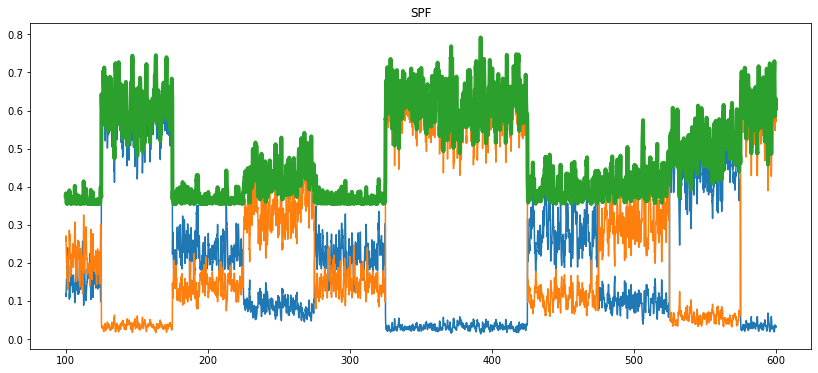

[0.03378001 0.57200509]


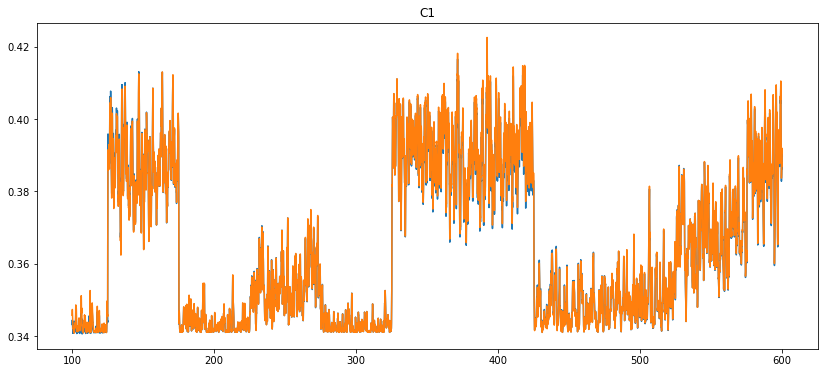

[0.3898707  0.39070446]


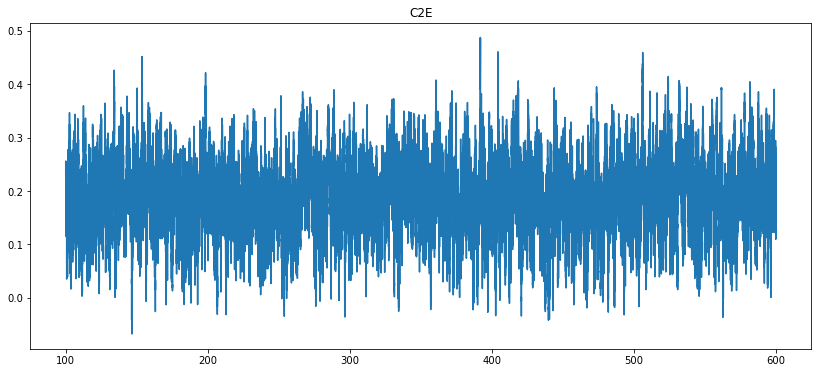

[0.14780577]


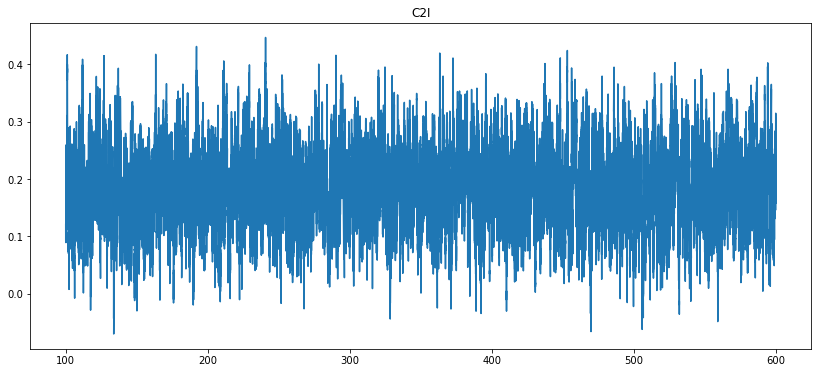

[0.30555908]


In [21]:
fs = (14,6)
# SPF
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF1+SPF2])
plt.plot(times, SPF_data.transpose())
plt.plot(times, np.sum(SPF_data, axis=0), linewidth=4)
plt.title('SPF')
plt.show()
print(SPF_data[:,-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C1])
plt.plot(times, C1_data.transpose())
plt.title('C1')
plt.show()
print(C1_data[:,-1])

# C2
C2E_fig = plt.figure(figsize=fs)
C2E_data = np.array(data[C2E])
plt.plot(times, C2E_data.transpose())
plt.title('C2E')
plt.show()
print(C2E_data[:,-1])

C2I_fig = plt.figure(figsize=fs)
C2I_data = np.array(data[C2I])
plt.plot(times, C2I_data.transpose())
plt.title('C2I')
plt.show()
print(C2I_data[:,-1])


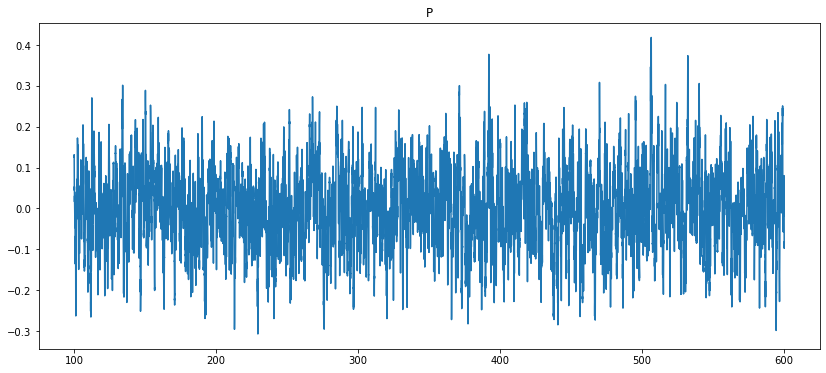

[-0.08194686]


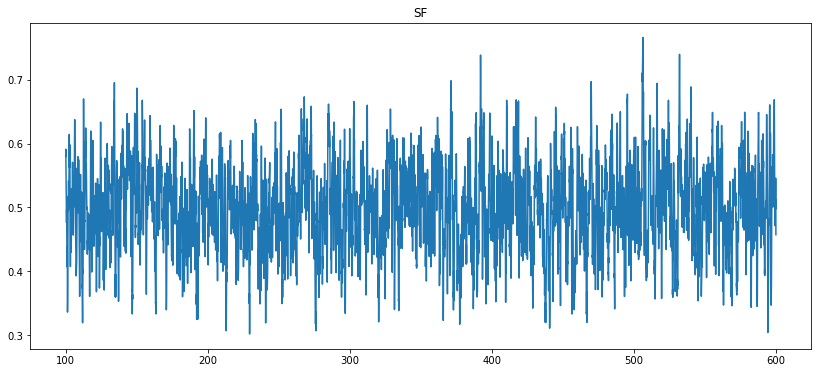

[0.45731279]
[0.030152]


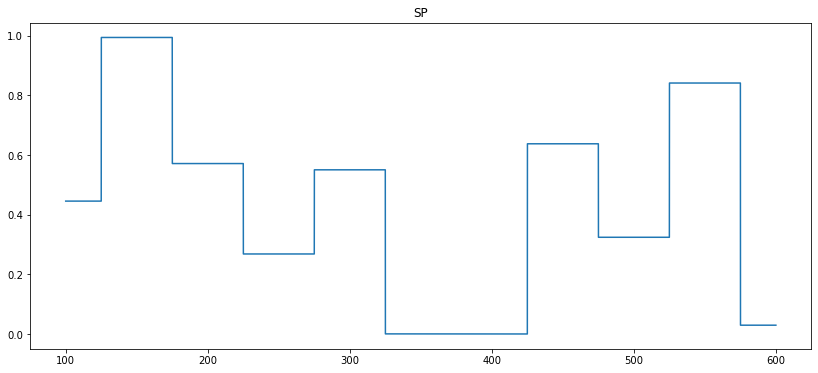

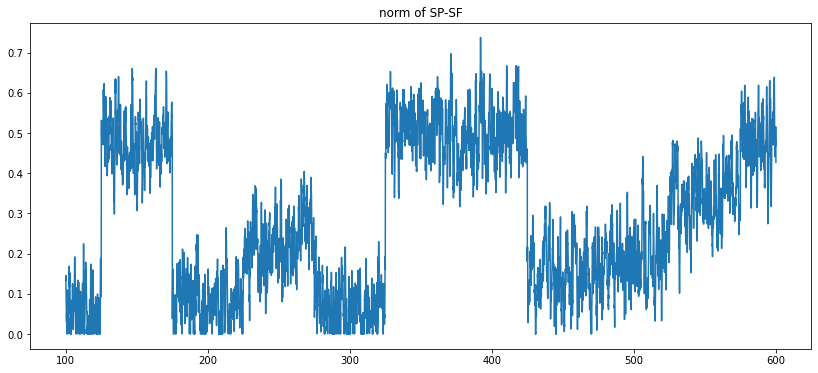

In [22]:
fs = (14,6)
# P
P_fig = plt.figure(figsize=fs)
P_data = np.array(data[P])
plt.plot(times, P_data.transpose())
plt.title('P')
plt.show()
print(P_data[:,-1])

# SF
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
plt.plot(times, SF_data.transpose())
plt.title('SF')
plt.show()
print(SF_data[:,-1])

# SP
SP_fig = plt.figure(figsize=fs)
SP_data = np.array(data[SP])
plt.plot(times, SP_data.transpose())
plt.title('SP')
print(SP_data[:,-1])

# SP-SF
SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
SP_SF_fig = plt.figure(figsize=fs)
plt.plot(times, SP_SF_norm)
plt.title('norm of SP-SF')
plt.show()


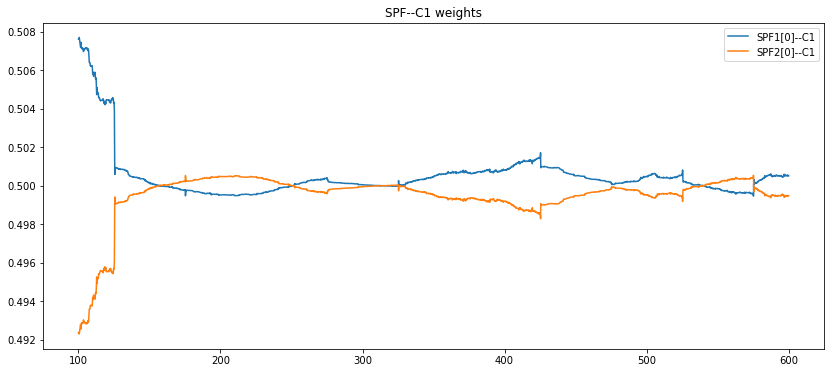

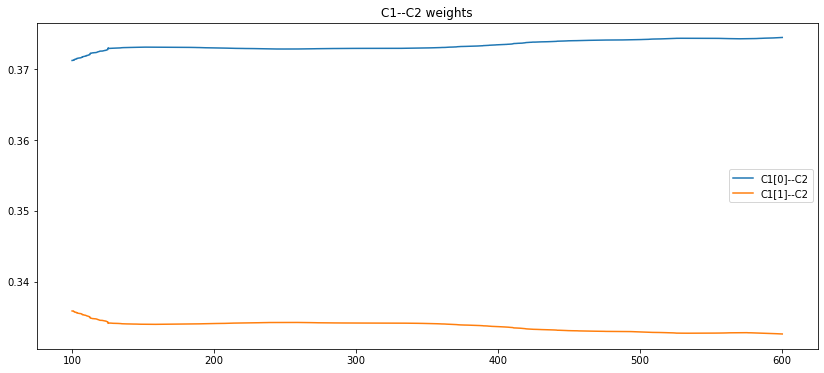

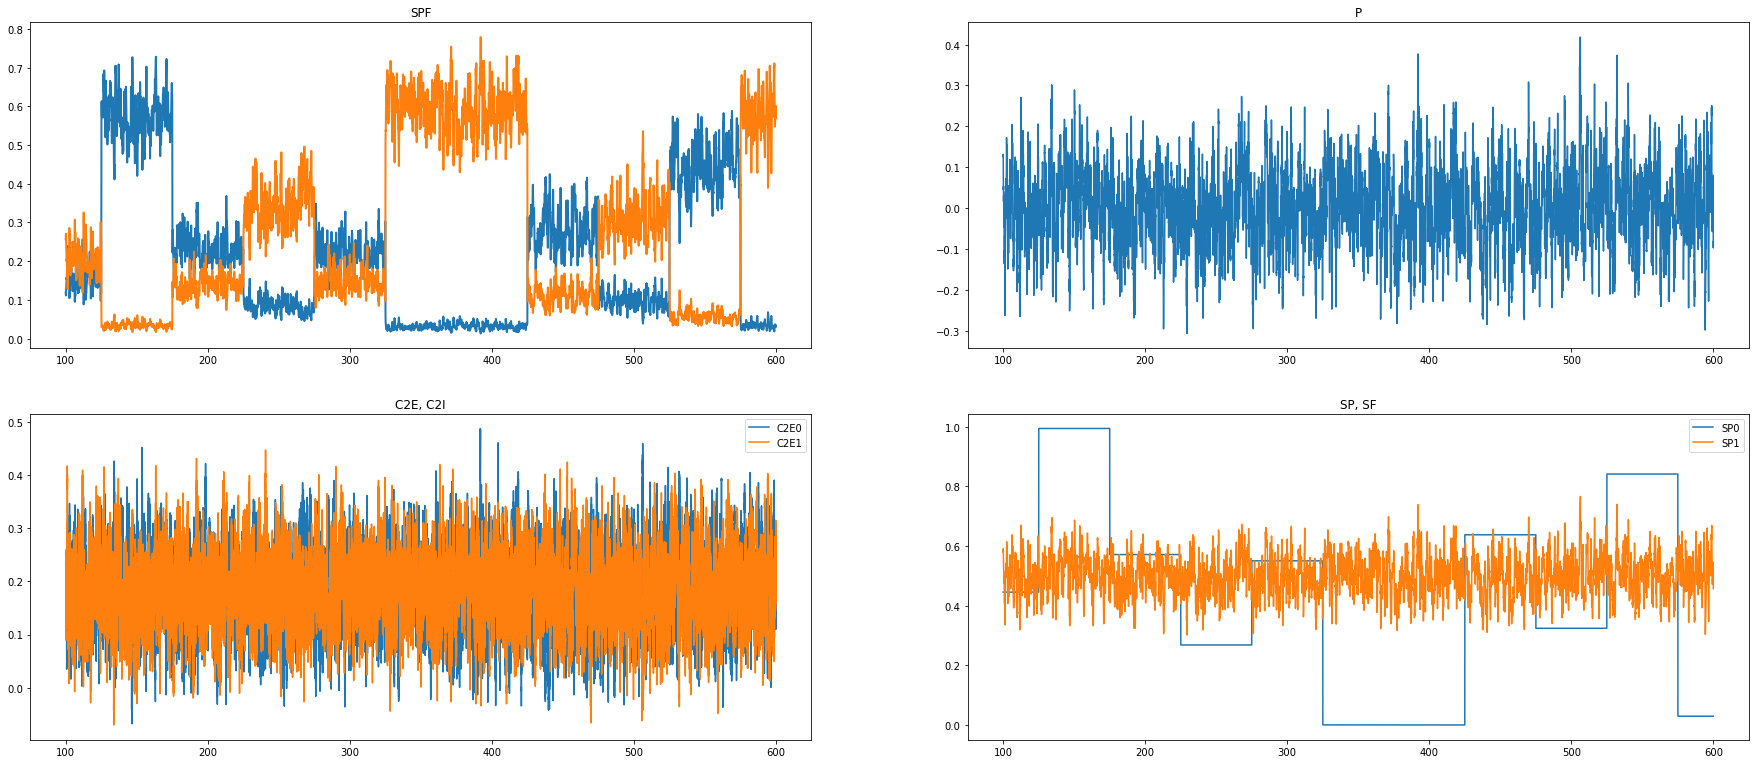

In [23]:
# weight tracking
W_fig1 = plt.figure(figsize=fs)
w_track_data1 = np.array(data[SPF__C1_track[0:N]])
w_track_data2 = np.array(data[SPF__C1_track[N:]])
plt.plot(times, w_track_data1.transpose())
SPF__C1_legends1 = ['SPF1['+str(i)+']--C1' for i in range(N)]
plt.plot(times, w_track_data2.transpose())
SPF__C1_legends2 = ['SPF2['+str(i)+']--C1' for i in range(N)]
plt.legend(SPF__C1_legends1+SPF__C1_legends2)
plt.title('SPF--C1 weights')

W_fig2 = plt.figure(figsize=fs)
w_track_data_c12 = np.array(data[C1__C2_track])
plt.plot(times, w_track_data_c12.transpose())
C1__C2_legends = ['C1['+str(i)+']--C2' for i in range(len(C1))]
plt.legend(C1__C2_legends)
plt.title('C1--C2 weights')


# joint plot
joint_fig, axs = plt.subplots(2, 2, figsize=(2.2*fs[0], 2.2*fs[1]))
axs[0][0].plot(times, SPF_data.transpose(), linewidth=2)
axs[0][0].set_title('SPF')
P_data = np.array(data[P])
axs[0][1].plot(times, P_data.transpose())
axs[0][1].set_title('P')
axs[1][0].plot(times, C2E_data.transpose())
axs[1][0].plot(times, C2I_data.transpose())
axs[1][0].legend(['C2E0', 'C2E1','C2E2', 'C2E3', 'C2I0', 'C2I1', 'C2I2', 'C2I3'])
axs[1][0].set_title('C2E, C2I')
axs[1][1].plot(times, SP_data.transpose())
axs[1][1].plot(times, SF_data.transpose())
axs[1][1].set_title('SP, SF')
axs[1][1].legend(['SP0', 'SP1', 'SF0', 'SF1'])

plt.show()

In [18]:
C_id = 0
for idx, syn in enumerate(net.syns[C2E[C_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in C2I:
        pre_pop = 'C2I'
    elif pre_id in C2E:
        pre_pop = 'C2E'
    elif pre_id in C1:
        pre_pop = 'C1'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> C2E[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, C_id, syn.w, syn.port))

0) C1 (0) --> C2E[0], w=0.371246, port=0
1) C1 (1) --> C2E[0], w=0.335862, port=0
2) C2I (3) --> C2E[0], w=-1.000000, port=1


In [19]:
C1_id = 1
for idx, syn in enumerate(net.syns[C1[C1_id]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in SPF1:
        pre_pop = 'SPF1'
    elif pre_id in SPF2:
        pre_pop = 'SPF2'
    elif pre_id in C2I:
        pre_pop = 'C2I'
    elif pre_id in C2E:
        pre_pop = 'C2E'
    elif pre_id in C1:
        pre_pop = 'C1'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> C1[%d], w=%f, port=%d'%(idx, pre_pop, pre_id, C_id, syn.w, syn.port))

0) C1 (0) --> C1[0], w=-1.000000, port=1
1) SPF1 (7) --> C1[0], w=0.492371, port=0
2) SPF2 (8) --> C1[0], w=0.507630, port=0


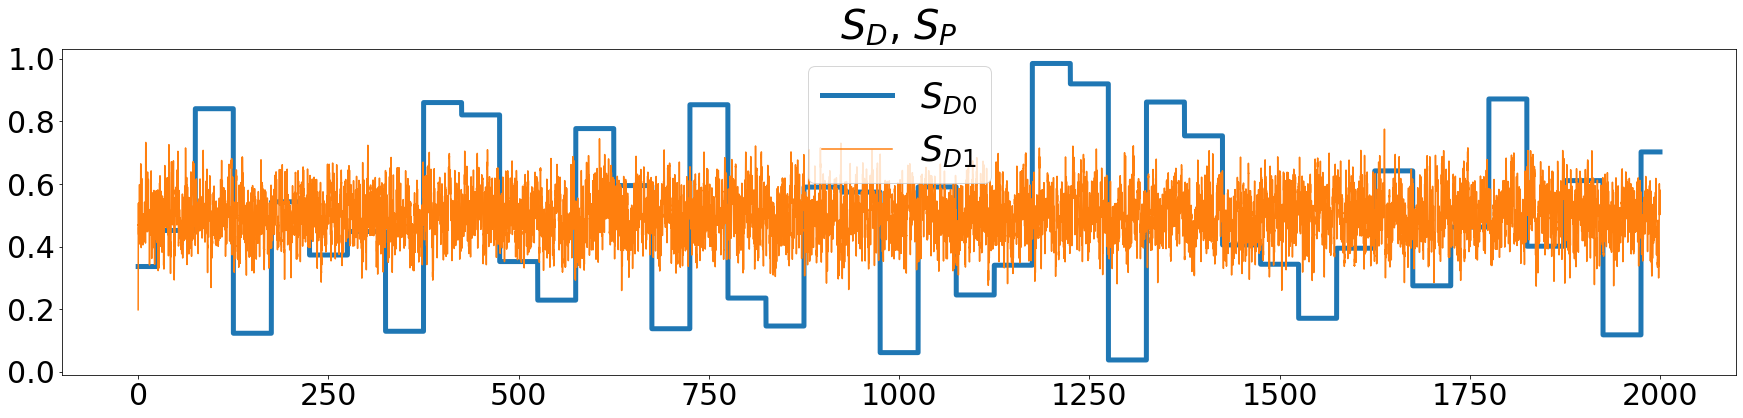

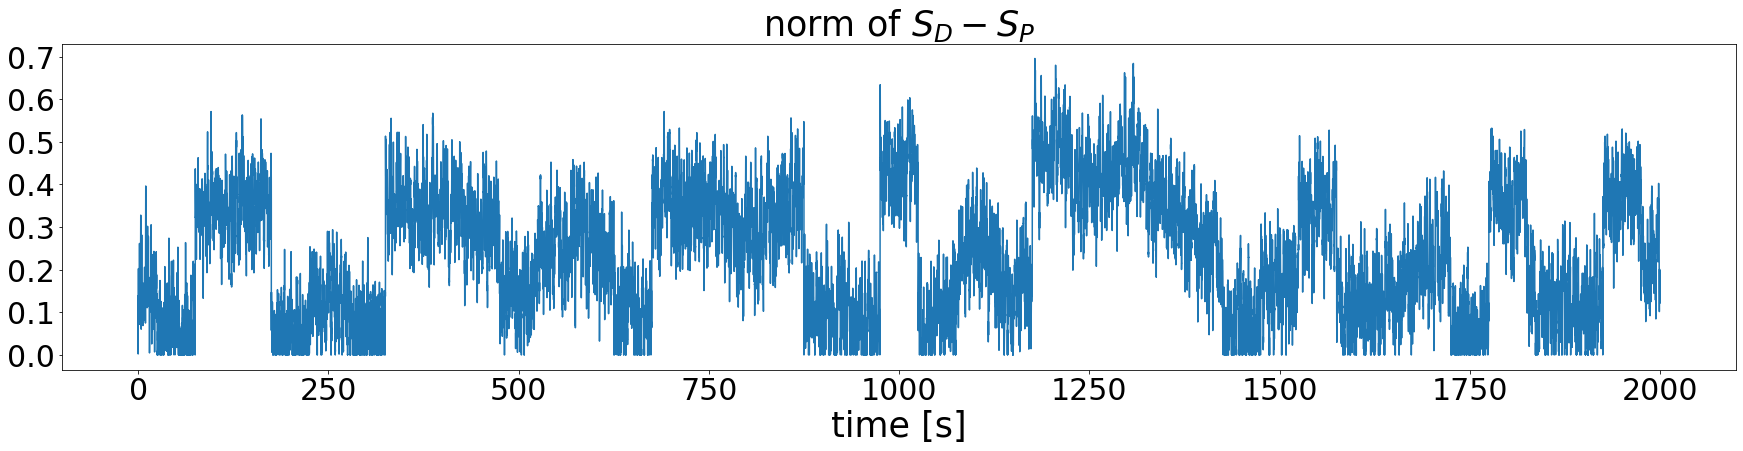

Mean of normalized S_P - SF norm: 0.240098


In [10]:
# Nicely formatted figures
figB = plt.figure(figsize=(30,6))
plt.plot(times, SP_data.transpose(), linewidth=5)
plt.plot(times, SF_data.transpose())
plt.title('$S_D$, $S_P$', fontsize=40)
plt.legend(['$S_{D0}$', '$S_{D1}$', '$S_{P0}$', '$S_{P1}$'], fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

if N > 1:
    SP_data_unit = (SP_data/np.linalg.norm(SP_data, axis=0))
    SF_data_unit = (SF_data/np.linalg.norm(SF_data, axis=0))
    SP_SF = SP_data_unit - SF_data_unit
else:
    SP_SF = SP_data - SF_data
SP_SF_norm = np.linalg.norm(SP_SF, axis=0)
figC = plt.figure(figsize=(30,6))
plt.plot(times, SP_SF_norm)
plt.title('norm of $S_D - S_P$', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('time [s]', fontsize=35)

plt.show()

print("Mean of normalized S_P - SF norm: %f" %(np.mean(SP_SF_norm)))

In [14]:
idx1 = int(np.round(SP_SF_norm.size/2.))
print("Mean of normalized S_P - SF norm (first half): %f" %(np.mean(SP_SF_norm[:idx1])))
print("Mean of normalized S_P - SF norm (second half): %f" %(np.mean(SP_SF_norm[idx1:])))

Mean of normalized S_P - SF norm (first half): 0.179485
Mean of normalized S_P - SF norm (second half): 0.104542
